# **Chess Board Extraction**

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.models import load_model  # Adjust based on your Unet implementation
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Initialize and load your model
model_name = 'Unet'
base = 4
frame_shape = (640, 640)  # Set the input frame shape
labels = sorted(['chess_board'])  # class label
hues = [30]  # class colour
hues_dict = {hue: label for label, hue in zip(labels, hues)}
n_classes = len(labels) + 1

In [13]:
class Unet:
    def __init__(self, model_name, base, n_classes, frame_shape, loss='categorical_crossentropy'):
        self.model_name = model_name
        self.base = base
        self.loss = loss
        self.n_classes = n_classes
        self.frame_shape = frame_shape

    @staticmethod
    def preprocess_input(x):
        x /= 255.
        x -= 0.5
        return x

    @staticmethod
    def dice(y_true, y_pred, smooth=1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def load_model(self, model_save_path, pretrained=False):
        if pretrained:
            try:
                model = self.get_model()
                model.load_weights(model_save_path)
                print(f"Model loaded successfully from {model_save_path}.")
                return model
            except Exception as e:
                print(f"Failed to load existing model at {model_save_path}: {e}")
                return None
        else:
            model = self.get_model()
            return model

    def get_model(self):
        model_input = tf.keras.layers.Input((self.frame_shape[0], self.frame_shape[1], 3))
        s = tf.keras.layers.Lambda(lambda x: self.preprocess_input(x))(model_input)

        c1 = tf.keras.layers.Conv2D(2 ** self.base, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
        c1 = tf.keras.layers.Dropout(0.1)(c1)
        c1 = tf.keras.layers.Conv2D(2 ** self.base, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
        p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

        c2 = tf.keras.layers.Conv2D(2 ** (self.base + 1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
        c2 = tf.keras.layers.Dropout(0.1)(c2)
        c2 = tf.keras.layers.Conv2D(2 ** (self.base + 1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
        p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

        c3 = tf.keras.layers.Conv2D(2 ** (self.base + 2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
        c3 = tf.keras.layers.Dropout(0.2)(c3)
        c3 = tf.keras.layers.Conv2D(2 ** (self.base + 2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
        p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

        c4 = tf.keras.layers.Conv2D(2 ** (self.base + 3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
        c4 = tf.keras.layers.Dropout(0.2)(c4)
        c4 = tf.keras.layers.Conv2D(2 ** (self.base + 3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
        p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

        c5 = tf.keras.layers.Conv2D(2 ** (self.base + 4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
        c5 = tf.keras.layers.Dropout(0.3)(c5)
        c5 = tf.keras.layers.Conv2D(2 ** (self.base + 4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

        u6 = tf.keras.layers.Conv2DTranspose(2 ** (self.base + 3), (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = tf.keras.layers.concatenate([u6, c4])
        c6 = tf.keras.layers.Conv2D(2 ** (self.base + 3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
        c6 = tf.keras.layers.Dropout(0.2)(c6)
        c6 = tf.keras.layers.Conv2D(2 ** (self.base + 3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

        u7 = tf.keras.layers.Conv2DTranspose(2 ** (self.base + 2), (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = tf.keras.layers.concatenate([u7, c3])
        c7 = tf.keras.layers.Conv2D(2 ** (self.base + 2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
        c7 = tf.keras.layers.Dropout(0.2)(c7)
        c7 = tf.keras.layers.Conv2D(2 ** (self.base + 2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

        u8 = tf.keras.layers.Conv2DTranspose(2 ** (self.base + 1), (2, 2), strides=(2, 2), padding='same')(c7)
        u8 = tf.keras.layers.concatenate([u8, c2])
        c8 = tf.keras.layers.Conv2D(2 ** (self.base + 1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
        c8 = tf.keras.layers.Dropout(0.1)(c8)
        c8 = tf.keras.layers.Conv2D(2 ** (self.base + 1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

        u9 = tf.keras.layers.Conv2DTranspose(2 ** self.base, (2, 2), strides=(2, 2), padding='same')(c8)
        u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
        c9 = tf.keras.layers.Conv2D(2 ** self.base, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
        c9 = tf.keras.layers.Dropout(0.1)(c9)
        c9 = tf.keras.layers.Conv2D(2 ** self.base, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

        model_output = tf.keras.layers.Conv2D(self.n_classes, (1, 1), activation="softmax")(c9)

        model = tf.keras.models.Model(inputs=model_input, outputs=model_output, name=self.model_name)
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=self.loss, metrics=[self.dice])
        model.summary()

        return model


unet = Unet(model_name=model_name, base=base, n_classes=n_classes, frame_shape=frame_shape)   # https://github.com/Vatsalparsaniya/Yolo-Segmentation-Chess/tree/main
model_save_path = '/content/drive/MyDrive/Chess/Unet.hdf5'  # Path to your model file

model = unet.load_model(model_save_path=model_save_path, pretrained=True)
if model is not None:
    print("Model loaded and ready for inference.")
else:
    print("Failed to load the model.")


Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 640, 640, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 640, 640, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 640, 640, 16)   │            448 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 640, 640, 16)   │              0 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 640, 640, 16)   │          2,320 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 320, 320, 16)   │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 320, 320, 32)   │          4,640 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 320, 320, 32)   │              0 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 320, 320, 32)   │          9,248 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 160, 160, 32)   │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 160, 160, 64)   │         18,496 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 160, 160, 64)   │              0 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 160, 160, 64)   │         36,928 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 80, 80, 64)     │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 80, 80, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 80, 80, 128)    │              0 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 80, 80, 128)    │        147,584 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11     

 Total params: 1,941,122 (7.40 MB)

 Trainable params: 1,941,122 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Model loaded successfully from /content/drive/MyDrive/Chess/Unet.hdf5.
Model loaded and ready for inference.


In [10]:
class InferenceModel:

    def __init__(self, model, model_input_shape=(frame_shape[0], frame_shape[1], 3)):
        self.model = model
        self.model_input_shape = model_input_shape  # (height, width, channel)

    def image_prediction_mask(self, image):

        image_height, image_width = image.shape[0], image.shape[1]
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_reshaped = cv2.resize(image_rgb, (self.model_input_shape[0], self.model_input_shape[1]))
        image_batch = np.expand_dims(image_reshaped, axis=0)
        prediction = self.model.predict(image_batch)[0]

        chess_board_mask = prediction[:, :, 0]
        # background_mask = prediction[:, :, 1]

        chess_board_mask = np.array(chess_board_mask * 255, dtype=np.uint8)

        reshaped_chess_board_mask = cv2.resize(chess_board_mask, (image_height, image_width))
        return reshaped_chess_board_mask

    @staticmethod
    def get_mask_corner_points(mask, method="contour"):

        if method == "contour":

            _, thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            if hierarchy is not None:

                cnt = max(contours, key=lambda x: cv2.contourArea(x))
                cnt_epsilon = 0.03 * cv2.arcLength(cnt, True)
                cnt_approx = cv2.approxPolyDP(cnt, cnt_epsilon, True)

                if len(cnt_approx) == 4:
                    return cnt_approx.reshape((4, 2))
                else:
                    return None
            else:
                return None

        if method == "goodFeaturesToTrack":

            corners = cv2.goodFeaturesToTrack(mask, maxCorners=4, qualityLevel=0.4, minDistance=100)

            if len(corners) == 4:
                return corners.reshape((4, 2))
            else:
                return None

    @staticmethod
    def get_order_points(pts):
        # first - top-left,
        # second - top-right
        # third - bottom-right
        # fourth - bottom-left

        rect = np.zeros((4, 2), dtype="float32")

        # top-left point will have the smallest sum
        # bottom-right point will have the largest sum
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        # top-right point will have the smallest difference
        # bottom-left will have the largest difference
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        return rect

    def point_transform(self, image, points):
        order_corner_points = self.get_order_points(points)

        height, width = image.shape[0], image.shape[1]

        dst = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]], dtype="float32")

        M = cv2.getPerspectiveTransform(order_corner_points, dst)
        warped_image = cv2.warpPerspective(image, M, (width, height))

        return warped_image

    def mask_check(self, corner_points, image):

        if corner_points is not None:
            order_points = self.get_order_points(corner_points)
            image_height, image_width = image.shape[0], image.shape[1]
            chess_board_padding = 5

            x1, y1 = order_points[0]  # top-left,
            x2, y2 = order_points[1]  # top-right
            x3, y3 = order_points[2]  # bottom-right
            x4, y4 = order_points[3]  # bottom-left

            if (chess_board_padding < x1 < image_width - chess_board_padding) and \
                    (chess_board_padding < y1 < image_height - chess_board_padding) and \
                    (x1 < x2 < image_width - chess_board_padding) and \
                    (chess_board_padding < y2 < image_height - chess_board_padding) and \
                    (chess_board_padding < x3 < image_width - chess_board_padding) and \
                    (y2 < y3 < image_height - chess_board_padding) and \
                    (chess_board_padding < x4 < image_width - chess_board_padding) and \
                    (y1 < y4 < image_height - chess_board_padding):
                return True
            else:
                return False
        else:
            return False

    def get_predicted_warped_image(self, image):

        mask = self.image_prediction_mask(image)
        corner_points = self.get_mask_corner_points(mask)

        if self.mask_check(corner_points, image):
            warped_image = self.point_transform(image, corner_points)
            return warped_image
        else:
            return None

    @staticmethod
    def draw_border(img, corner_points):

        x1, y1 = corner_points[0]  # top-left,
        x2, y2 = corner_points[1]  # top-right
        x3, y3 = corner_points[2]  # bottom-right
        x4, y4 = corner_points[3]  # bottom-left

        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)  # top-left -- top-right
        cv2.line(img, (x2, y2), (x3, y3), (255, 0, 0), 3)  # top-right -- bottom-right
        cv2.line(img, (x3, y3), (x4, y4), (255, 0, 0), 3)  # bottom-right -- bottom-left
        cv2.line(img, (x4, y4), (x1, y1), (255, 0, 0), 3)  # bottom-left -- top-left

        cv2.circle(img, (x1, y1), 4, (0, 0, 255), -1)  # top-left,
        cv2.circle(img, (x3, y3), 4, (0, 0, 255), -1)  # top-right
        cv2.circle(img, (x4, y4), 4, (0, 0, 255), -1)  # bottom-right
        cv2.circle(img, (x2, y2), 4, (0, 0, 255), -1)  # bottom-left

        return img

    def get_marked_border_image(self, image):

        mask = self.image_prediction_mask(image)
        corner_points = self.get_mask_corner_points(mask)

        if self.mask_check(corner_points, image):
            border_image = self.draw_border(image, corner_points)
            return border_image
        else:
            # cv2.putText(image, "Border Not Detected", (10, 10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 0, 255), 2)
            return image



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


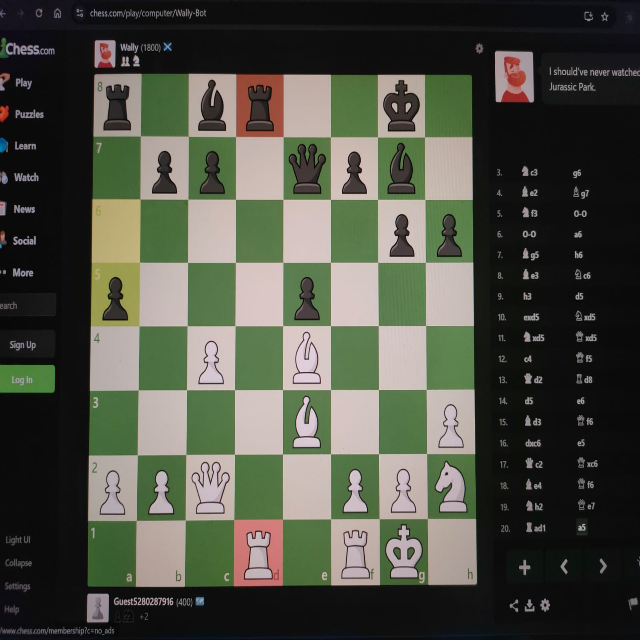

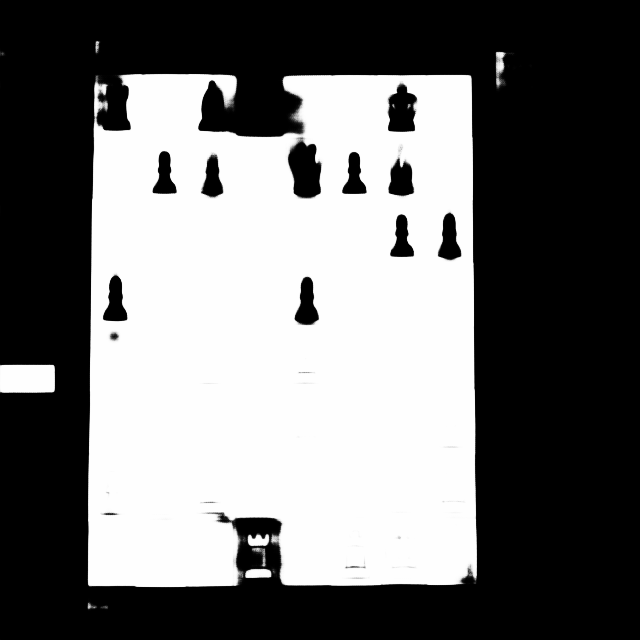

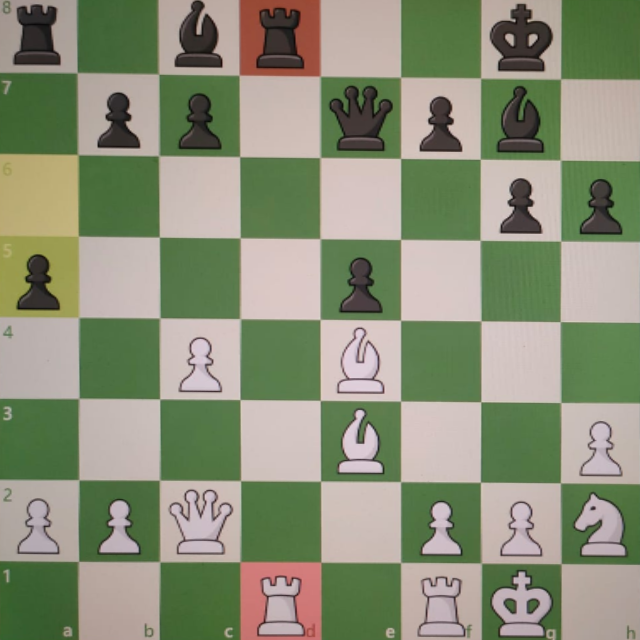

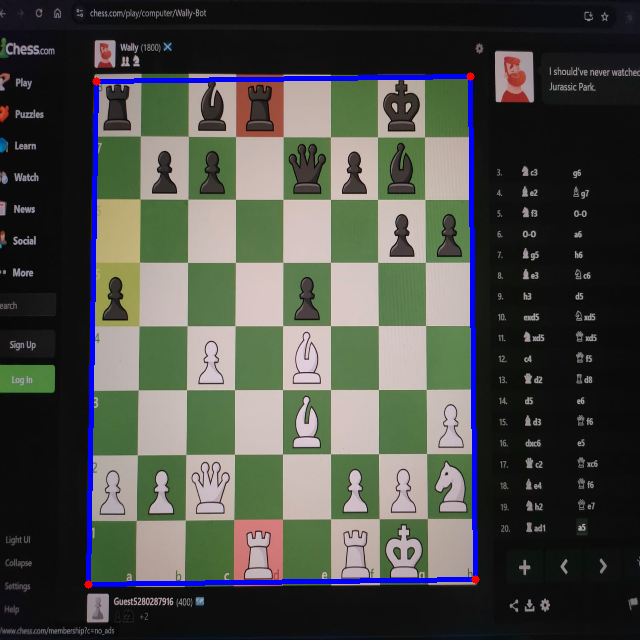

In [14]:
inference_model = InferenceModel(model)

image = cv2.imread("/content/demo.jpg")  # Path to your image
image = cv2.resize(image, (frame_shape[0], frame_shape[1]))  # same as frame_shape

warped_predicted_image = inference_model.get_predicted_warped_image(image)
mask = inference_model.image_prediction_mask(image)
border_image = inference_model.get_marked_border_image(image.copy())

cv2_imshow(image)
cv2_imshow(mask)
cv2_imshow(warped_predicted_image)
cv2_imshow(border_image)


# **Chess Piece Detection**

In [15]:
import os
import cv2
import sys
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.


0: 640x640 2 bbs, 1 bk, 7 bps, 1 bq, 2 brs, 2 wbs, 1 wk, 1 wn, 6 wps, 1 wq, 2 wrs, 3900.4ms
Speed: 2.8ms preprocess, 3900.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


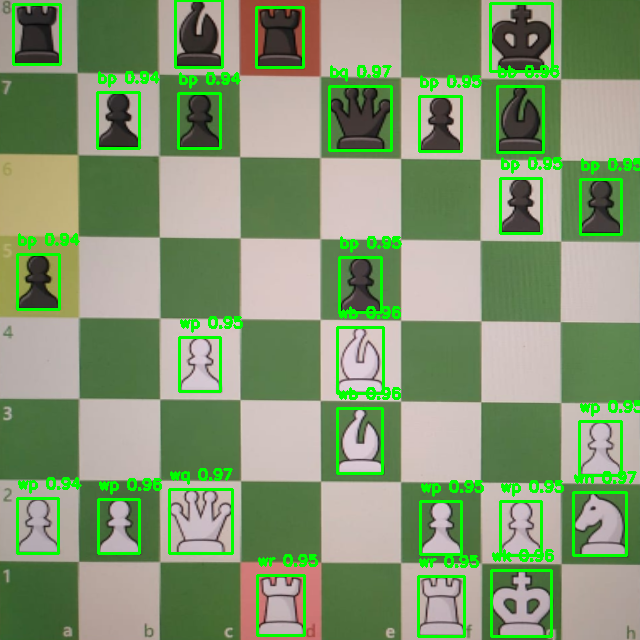

In [21]:
# Load the YOLOv8 model
model = YOLO('/content/drive/MyDrive/Chess/best.pt')

# Extract the class names from the model
class_names = list(model.names.values())   # ['bb', 'bk', 'bn', 'bp', 'bq', 'br', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr']

# Read the image using OpenCV
image = cv2.imread("//content/download.png")
frame_shape = (640, 640)  # Set the input frame shape
image = cv2.resize(image, (frame_shape[0], frame_shape[1]))  # same as frame_shape

# Perform inference on the image
results = model(image)


# Define confidence threshold
confidence_threshold = 0.8

# Process and draw the results on the image
for result in results:
    for box in result.boxes:
        # Get confidence score
        confidence = box.conf[0]

        # Only consider predictions above the confidence threshold
        if confidence > confidence_threshold:
            # Extract bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Get class id
            class_id = int(box.cls[0])

            # Get the class name
            class_name = class_names[class_id]

            # Draw the bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Put the class name and confidence on the image
            label = f"{class_name} {confidence:.2f}"
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image
cv2_imshow(image)

# **Fenline Generation**

In [17]:
import cv2
import numpy as np
import os
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

In [22]:
# Load the YOLOv8 model
model_path = "/content/drive/MyDrive/Chess/best.pt"

# Extract the class names
classes = ['bb', 'bk', 'bn', 'bp', 'bq', 'br', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr']

# FEN config
class_fen_dict = {'wr': "R", 'wn': "N", 'wk': "K", 'wq': "Q",
                  'wb': "B", 'wp': "P", 'bp': "p", 'br': "r",
                  'bn': "n", 'bb': "b", 'bk': "k", 'bq': "q"}

# Define the input frame shape
frame_shape = (640, 640)  # Set the input frame shape

In [23]:
class ChessboardFENGenerator:
    def __init__(self, model_path, class_fen_dict, classes, width, height, confidence_threshold=0.8):
        self.model = YOLO(model_path)
        self.class_fen_dict = class_fen_dict
        self.classes = classes
        self.width = width
        self.height = height
        self.confidence_threshold = confidence_threshold
        self.grid_size = (self.width // 8, self.height // 8)

    def detect_pieces(self, image):
        results = self.model(image)
        boxes, classes, confidences = [], [], []
        for result in results:
            for box in result.boxes:
                if box.conf[0] > self.confidence_threshold:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    class_id = int(box.cls[0])
                    boxes.append((x1, y1, x2, y2))
                    classes.append(self.classes[class_id])
                    confidences.append(box.conf[0])
        return boxes, classes

    def get_board_grid(self):
        return np.array([[
            [x * self.grid_size[0], y * self.grid_size[1]],
            [(x + 1) * self.grid_size[0], y * self.grid_size[1]],
            [(x + 1) * self.grid_size[0], (y + 1) * self.grid_size[1]],
            [x * self.grid_size[0], (y + 1) * self.grid_size[1]]
        ] for y in range(8) for x in range(8)], dtype=np.int32)

    def generate_fen(self, image, who_turn='w'):
        boxes, detected_classes = self.detect_pieces(image)
        grid_contours = self.get_board_grid()
        board = np.full((8, 8), '.')

        for i, (x1, y1, x2, y2) in enumerate(boxes):
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            for grid_index, grid_box in enumerate(grid_contours):
                if cv2.pointPolygonTest(grid_box, (cx, cy), False) > 0:
                    row, col = divmod(grid_index, 8)
                    board[row, col] = self.class_fen_dict.get(detected_classes[i], '.')
                    break

        return self.board_to_fen(board, who_turn), board

    @staticmethod
    def board_to_fen(board, who_turn):
        def rank_to_fen(rank):
            result = ''
            empty_count = 0
            for cell in rank:
                if cell == '.':
                    empty_count += 1
                else:
                    if empty_count > 0:
                        result += str(empty_count)
                        empty_count = 0
                    result += cell
            if empty_count > 0:
                result += str(empty_count)
            return result

        return '/'.join(map(rank_to_fen, board.tolist())) + f' {who_turn} KQkq - 0 1'

    def visualize_board(self, board, image):
        for row in range(8):
            for col in range(8):
                piece = board[row, col]
                if piece != '.':
                    x1 = col * self.grid_size[0]
                    y1 = row * self.grid_size[1]
                    x2 = (col + 1) * self.grid_size[0]
                    y2 = (row + 1) * self.grid_size[1]
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(image, piece, (x1 + 10, y1 + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        return image

    @staticmethod
    def board_to_string(board):
        board_str = ""
        for row in board:
            for cell in row:
                board_str += cell + " "
            board_str += "\n"
        return board_str


0: 640x640 2 bbs, 1 bk, 7 bps, 1 bq, 2 brs, 2 wbs, 1 wk, 1 wn, 6 wps, 1 wq, 2 wrs, 3154.5ms
Speed: 3.4ms preprocess, 3154.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
FEN Line: r1br2k1/1pp1qpb1/6pp/p3p3/2P1B3/4B2P/PPQ2PPN/3R1RK1 w KQkq - 0 1
Board Matrix:
 r . b r . . k . 
. p p . q p b . 
. . . . . . p p 
p . . . p . . . 
. . P . B . . . 
. . . . B . . P 
P P Q . . P P N 
. . . R . R K . 



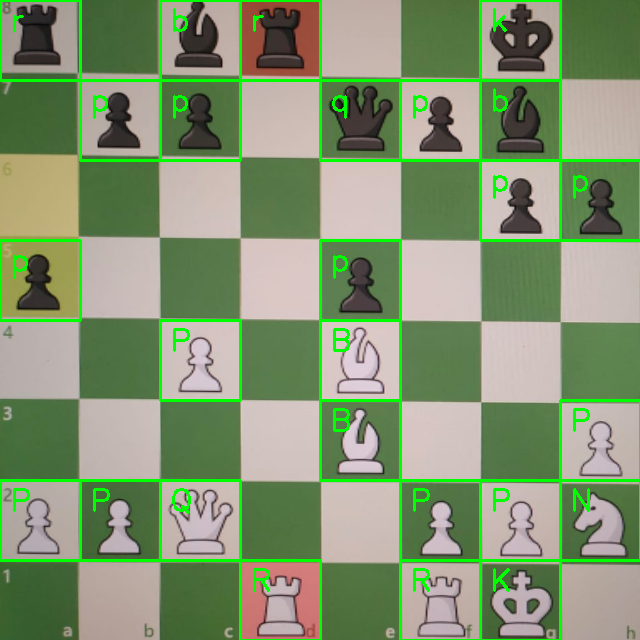

In [24]:
fen_generator = ChessboardFENGenerator(model_path, class_fen_dict, classes, frame_shape[0], frame_shape[1])

image_path = '/content/download.png'
image = cv2.imread(image_path)
image = cv2.resize(image, (frame_shape[0], frame_shape[1]))

fen_line, board_matrix = fen_generator.generate_fen(image)
print("FEN Line:", fen_line)

# Visualize the board matrix
visualized_image = fen_generator.visualize_board(board_matrix, image)

# Convert board matrix to string
board_string = fen_generator.board_to_string(board_matrix)
print("Board Matrix:\n", board_string)

# Display the image
cv2_imshow(visualized_image)

# **Best Move**

In [25]:
!pip install chess
# The next command will copy a shared library to the notebook. The library was compiled on Colab with sources provided by https://github.com/dshawul/nnue-probe
# Also a stockfish (https://github.com/official-stockfish/Stockfish) NNUE network will be copied to the notebook
# Ignore this error messages: destination path './nnue_lib' already exists and is not an empty directory.
!git clone https://github.com/aichess-project/nnue_lib/ ./nnue_lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.2 MB/s eta 0:00:00
Cloning into './nnue_lib'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 3), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 23.34 MiB | 5.49 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [27]:
import chess
from ctypes import *

class ChessEngine_v04:
    def __init__(self, fen=None, search_depth=3):
        # Initialize the chess board with optional FEN setup and search depth
        self.search_depth = search_depth
        if fen:
            self.board = chess.Board(fen)
        else:
            self.board = chess.Board()
        self.nnue = cdll.LoadLibrary("/content/nnue_lib/libnnueprobe.so")
        self.nnue.nnue_init(b"/content/nnue_lib/nn-04cf2b4ed1da.nnue")
        #self.nnue.nnue_init(b"/content/nnue_lib/nn-ab137a1399f2.nnue")

    def display_board(self):
        # Display the current state of the chess board with row and column ids and padding
        padding = " "
        print(padding + "   a b c d e f g h  ")
        print(padding + " +-----------------+")
        for i in range(8, 0, -1):
            row = f"{padding}{i}| "
            for j in range(1, 9):
                square = chess.square(j - 1, i - 1)
                piece = self.board.piece_at(square)
                if piece:
                    row += f"{piece.symbol()} "
                else:
                    row += ". "
            row += f"|{i}"
            print(row)
        print(padding + " +-----------------+")
        print(padding + "   a b c d e f g h  \n\n")

    def make_move(self, move):
        # Make a move on the chess board
        if move in self.board.legal_moves:
            self.board.push(move)
        else:
            print("Invalid move. Please make a legal move.")

    def evaluate_board(self):
        # Evaluate the current state of the board
        if self.board.is_checkmate():
            return float('-inf') if self.board.turn else float('inf')  # Checkmate, return a very low or high score
        elif self.board.is_stalemate() or self.board.is_insufficient_material():
            return 0  # Stalemate or insufficient material, the game is a draw
        else:
            return self.nnue.nnue_evaluate_fen(bytes(self.board.fen(), encoding='utf-8')) / -210.

    def minimax(self, depth, maximizing_player):
        # MiniMax algorithm with alpha-beta pruning
        if depth == 0 or self.board.is_game_over():
            return self.evaluate_board()

        legal_moves = list(self.board.legal_moves)

        if maximizing_player:
            max_eval = float('-inf')
            for move in legal_moves:
                self.board.push(move)
                eval = self.minimax(depth - 1, False)
                self.board.pop()
                max_eval = max(max_eval, eval)
            return max_eval
        else:
            min_eval = float('inf')
            for move in legal_moves:
                self.board.push(move)
                eval = self.minimax(depth - 1, True)
                self.board.pop()
                min_eval = min(min_eval, eval)
            return min_eval

    def get_best_move(self):
        # Find the best move using MiniMax with alpha-beta pruning and the specified search depth
        legal_moves = list(self.board.legal_moves)
        best_move = legal_moves[0]
        best_eval = float('-inf') if self.board.turn else float('inf')

        for move in legal_moves:
            self.board.push(move)
            eval = self.minimax(self.search_depth - 1, self.board.turn == chess.WHITE)
            self.board.pop()
            if (self.board.turn and eval > best_eval) or (not self.board.turn and eval < best_eval):
                best_eval = eval
                best_move = move
        return best_move, best_eval

# Main program to get best move for a single FEN string and display the board
if __name__ == "__main__":
    fen_string = "r1br2k1/1pp1qpb1/6pp/p3p3/2P1B3/4B2P/PPQ2PPN/3R1RK1 w KQkq - 0 1"  # Replace with your FEN string
    chess_engine = ChessEngine_v04(fen=fen_string)

    # Display the board
    chess_engine.display_board()

    # Get the best move for the given FEN string
    best_move, eval_score = chess_engine.get_best_move()
    print(f"Best move: {best_move}, Evaluation: {eval_score}")

    # Display the board after the best move is made
    chess_engine.make_move(best_move)
    chess_engine.display_board()


    a b c d e f g h  
  +-----------------+
 8| r . b r . . k . |8
 7| . p p . q p b . |7
 6| . . . . . . p p |6
 5| p . . . p . . . |5
 4| . . P . B . . . |4
 3| . . . . B . . P |3
 2| P P Q . . P P N |2
 1| . . . R . R K . |1
  +-----------------+
    a b c d e f g h  


Best move: e4f3, Evaluation: 4.9714285714285715
    a b c d e f g h  
  +-----------------+
 8| r . b r . . k . |8
 7| . p p . q p b . |7
 6| . . . . . . p p |6
 5| p . . . p . . . |5
 4| . . P . . . . . |4
 3| . . . . B B . P |3
 2| P P Q . . P P N |2
 1| . . . R . R K . |1
  +-----------------+
    a b c d e f g h  


